# Custom RAG Pipeline

A RAG pipeline built using open-source models for retrieving answers from specific sources. For this project, we use pdf as our primary data source, Llama-13b as our query responder model and Sentence-Transformers all-mpnet-base-v2 as embedding model. High-level architecture can be found below: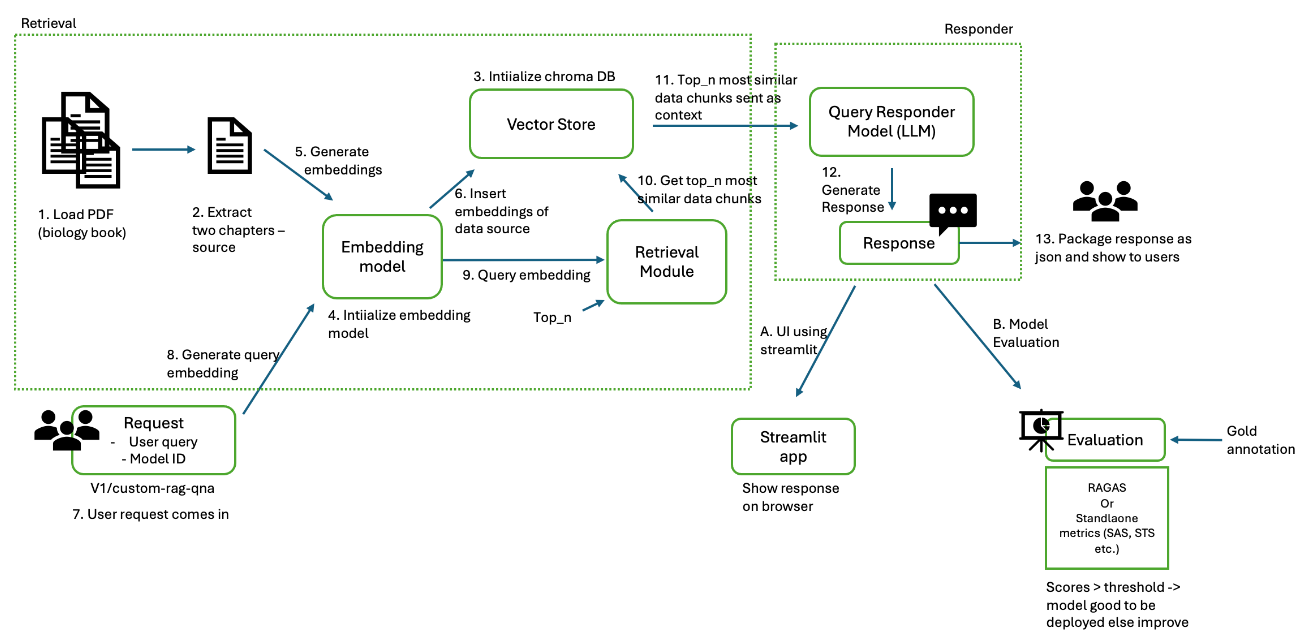

### **Assumptions**
- It is a non-conversational search system without any need for a memory buffer
- The only data source for this pipeline are the two chapters from biology book shared in assignment. Code currently supports no other data loaders.
- All queries use same data source as data is indexed in vector store before requests start coming in
- We use top-2 most similar document chunks as context to generate response
- There is no need to validate/monitor filters such as client, user logged in state etc.
- We only have access to Llama-13b which is used as query responder model

### Install packages

In [ ]:
!pip install llama-index llama-index-llms-huggingface pypdf2 llama-index-embeddings-huggingface llama-index-vector-stores-chroma llama-cpp-python llama-index-llms-llama-cpp sentence_transformers rouge_score

### Imports

In [39]:
import datetime
from typing import List, Any
import pandas as pd
import numpy as np
from numpy.linalg import norm
import torch
import tensorflow as tf

import chromadb
from PyPDF2 import PdfReader, PdfWriter
from sentence_transformers import SentenceTransformer
from sentence_transformers.cross_encoder import CrossEncoder
from rouge_score import rouge_scorer
from llama_index.core import SimpleDirectoryReader
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.schema import TextNode
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core import QueryBundle
from llama_index.core.schema import NodeWithScore
from llama_index.core.vector_stores import VectorStoreQuery
from llama_index.llms.llama_cpp import LlamaCPP
from llama_index.core.retrievers import BaseRetriever

### 1. Prepare Data

In [3]:
# Download pdf - biology book

!wget https://assets.openstax.org/oscms-prodcms/media/documents/ConceptsofBiology-WEB.pdf?_gl=1*9nr3zf*_ga*ODEzMjMyMTEzLjE3MTAyNTMwNjk.*_ga_T746F8B0QC*MTcxMDI1MzA2OC4xLjAuMTcxMDI1MzA2OS41OS4wLjA.

--2024-03-15 13:34:44--  https://assets.openstax.org/oscms-prodcms/media/documents/ConceptsofBiology-WEB.pdf?_gl=1*9nr3zf*_ga*ODEzMjMyMTEzLjE3MTAyNTMwNjk.*_ga_T746F8B0QC*MTcxMDI1MzA2OC4xLjAuMTcxMDI1MzA2OS41OS4wLjA.
Resolving assets.openstax.org (assets.openstax.org)... 3.163.165.116, 3.163.165.28, 3.163.165.65, ...
Connecting to assets.openstax.org (assets.openstax.org)|3.163.165.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153179709 (146M) [application/pdf]
Saving to: ‘ConceptsofBiology-WEB.pdf?_gl=1*9nr3zf*_ga*ODEzMjMyMTEzLjE3MTAyNTMwNjk.*_ga_T746F8B0QC*MTcxMDI1MzA2OC4xLjAuMTcxMDI1MzA2OS41OS4wLjA..1’

ConceptsofBiology-W 100%[===================>] 146.08M   175MB/s    in 0.8s    

2024-03-15 13:34:44 (175 MB/s) - ‘ConceptsofBiology-WEB.pdf?_gl=1*9nr3zf*_ga*ODEzMjMyMTEzLjE3MTAyNTMwNjk.*_ga_T746F8B0QC*MTcxMDI1MzA2OC4xLjAuMTcxMDI1MzA2OS41OS4wLjA..1’ saved [153179709/153179709]



In [4]:
# Extract text from source i.e. pdf and load it in directory
# reader loader by llamaindex for easy access during retrieval.

pdf_file_path = "/content/ConceptsofBiology-WEB.pdf?_gl=1*9nr3zf*_ga*ODEzMjMyMTEzLjE3MTAyNTMwNjk.*_ga_T746F8B0QC*MTcxMDI1MzA2OC4xLjAuMTcxMDI1MzA2OS41OS4wLjA."
file_base_name = pdf_file_path.replace('.pdf', '')

pdf = PdfReader(pdf_file_path)
pdfWriter = PdfWriter()

# Extract first two chapter only
for page_num in range(18, 68):
    pdfWriter.add_page(pdf.pages[page_num])

with open('{0}_2chapters.pdf'.format(file_base_name), 'wb') as f:
    pdfWriter.write(f)
    f.close()

# Load in directory reader
documents = SimpleDirectoryReader(
    input_files=['{0}_2chapters.pdf'.format(file_base_name)]).load_data()

In [5]:
# Split source dato into chunks using sentence level splitter

chunk_size = 1024
text_parser = SentenceSplitter(
                chunk_size=chunk_size,
            )
text_chunks = []

# Retain relationship with source doc index; helps to inject doc metadata
doc_idxs = []
for doc_idx, doc in enumerate(documents):
    cur_text_chunks = text_parser.split_text(doc.text)
    text_chunks.extend(cur_text_chunks)
    doc_idxs.extend([doc_idx] * len(cur_text_chunks))

nodes = []
for idx, text_chunk in enumerate(text_chunks):
    node = TextNode(
        text=text_chunk,
    )
    src_doc = documents[doc_idxs[idx]]
    node.metadata = src_doc.metadata
    nodes.append(node)

### 2. Prepare Vector Store

In [11]:
# Initialize client
chroma_client = chromadb.EphemeralClient()

# Get or create collection
ch_collection_name = "customragpipeline"
chroma_collection = chroma_client.get_or_create_collection(ch_collection_name)

# Set up ChromaVectorStore
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

In [17]:
# Initialize embedding model
# Note: using all-MiniLM-L6-v2 instead of all-mpnet-base-v2 as in code as latter generating error on colab

embed_model = HuggingFaceEmbedding("sentence-transformers/all-MiniLM-L6-v2")

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# To-Do: Reduced to 5 for testing
nodes = nodes[0:5]

# Generate embeddings
for node in nodes:
    node_embedding = embed_model.get_text_embedding(
        node.get_content(metadata_mode="all")
    )
    node.embedding = node_embedding


# Add chunked data to vector store
vector_store.add(nodes)

### 3. Initialize LLM

Using llama-13b model as query responder

In [20]:
model_url = "https://huggingface.co/TheBloke/Llama-2-13B-chat-GGUF/resolve/main/llama-2-13b-chat.Q4_0.gguf"

In [ ]:
llm = LlamaCPP(
      model_url=model_url,
      temperature=1.0,
      max_new_tokens=256,
      context_window=3900,
      generate_kwargs={},
      verbose=True
  )

### 5. Initialize Retriever

Retrieves top-2 most similar docs for each user query

In [31]:
class VectorDBRetriever(BaseRetriever):
    """Retriever over a chroma vector store."""

    def __init__(
        self,
        vector_store: ChromaVectorStore,
        embed_model: Any,
        query_mode: str = "default",
        similarity_top_k: int = 2,
    ) -> None:
        """Init params."""
        self._vector_store = vector_store
        self._embed_model = embed_model
        self._query_mode = query_mode
        self._similarity_top_k = similarity_top_k
        super().__init__()

    def _retrieve(self, query_bundle: QueryBundle) -> List[NodeWithScore]:
        """Retrieve."""
        query_embedding = embed_model.get_query_embedding(
            query_bundle.query_str
        )
        vector_store_query = VectorStoreQuery(
            query_embedding=query_embedding,
            similarity_top_k=self._similarity_top_k,
            mode=self._query_mode,
        )
        query_result = vector_store.query(vector_store_query)

        nodes_with_scores = []
        for index, node in enumerate(query_result.nodes):
            score: Optional[float] = None
            if query_result.similarities is not None:
                score = query_result.similarities[index]
            nodes_with_scores.append(NodeWithScore(node=node, score=score))

        return nodes_with_scores

In [34]:
retriever = VectorDBRetriever(
    vector_store, embed_model, query_mode="default", similarity_top_k=2
)

### 4. Generate response using top-n most similar docs

In [33]:
user_query = "what is biology"

In [35]:
# initialize query engine that sends in top-2 most similar docs to llm

query_engine = RetrieverQueryEngine.from_args(retriever, llm=llm)

In [ ]:
# generate response

response = query_engine.query(user_query)

In [ ]:
print(f"Response generated by custom RAG pipeline: {str(response)}")

### 5. Evaluation



To build a comprehensive pipeline, we should ideally look at 3 kinds of metrics:

- **Data Science (DS)** metrics: such as relevancy, factual correctness etc.
- **Performance** metrics: such as latency, throughput etc.
- **Cost** analysis: overall cost in terms of resources etc.

However, due to time constraints, we primarily focus on DS metrics for this project. We use four DS metrics to evaluate our pipeline:

1. **STS (Semantic Textual Similarity):** Determines how similar cosine embeddings of generated and gold annotated responses are. Range: 0-1
2. **SAS (Semantic Answer Similarity**): Determines similarity score between a pair of generated and gold annotated responses. Range: 0-1
3. **ROUGE-L (Recall-Oriented Understudy for Gisting Evaluation - Longest Common Subsequence (LCS))**: Takes into account sentence-level structure similarity naturally and identifies longest co-occurring in sequence n-grams automatically. Range: 0-1
4. **Aggregated_Metric** - A weighted function of all previous response-level metrics. This metric gives highest max weightage to STS followed by equal weightage to SAS and ROUGE. These weights are chosen randomly and are subject to change based on findings.

In [13]:
## Initialize models

STS_EMBEDDING_MODEL = 'sentence-transformers/multi-qa-MiniLM-L6-cos-v1'
SAS_CROSS_ENCODER = 'sentence-transformers/stsb-roberta-large'

sts_model = SentenceTransformer(f'{STS_EMBEDDING_MODEL}')
sas_scorer = CrossEncoder(f'{SAS_CROSS_ENCODER}')

In [15]:
## Helper functions to compute metrics

def vector_similarity(vector_1, vector_2):
    """
    Returns the cosine similarity between two vectors.
    """
    dot_product = np.dot(np.array(vector_1), np.array(vector_2))
    l2_norm = norm(np.array(vector_1)) * norm(np.array(vector_2))
    return dot_product / l2_norm

def get_sts_embedding(sentences):
    embeddings = sts_model.encode(sentences)
    return embeddings


def compute_STS_metrics(generated_answers, gold_answers):
    answer_embedding = get_sts_embedding(generated_answers)
    gold_embedding = get_sts_embedding(gold_answers)
    scores = []
    for i in range(len(answer_embedding)):
        scores.append(vector_similarity(answer_embedding[i], gold_embedding[i]))
    return list(scores)


def compute_ROUGE_metrics(generated_answers, gold_answers):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = []
    for i in range(len(generated_answers)):
        scores.append(scorer.score(gold_answers[i], generated_answers[i])["rougeL"][2])
    return list(scores)


def compute_SAS_metrics(generated_answers, gold_answers):
    with torch.no_grad():
        scores = sas_scorer.predict(list(zip(generated_answers, gold_answers)))
    return list(scores)

In [ ]:
## Main function to compute metrics

def compute_metrics(generated_answers, gold_answers):
    rouge_scores = compute_ROUGE_metrics(generated_answers, gold_answers)
    sts_scores = compute_STS_metrics(generated_answers, gold_answers)
    sas_scores = compute_SAS_metrics(generated_answers, gold_answers)
    weighted_metrics = [rouge_scores[i] * 0.25 +
                        sts_scores[i] * 0.50 +
                        sas_scores[i] * 0.25 for i in range(len(rouge_scores))]
    metrics = pd.DataFrame(zip(rouge_scores, sts_scores, sas_scores, weighted_metrics),
                           columns=['ROUGE', 'STS', 'SAS', 'Aggregated_Metric'])
    return metrics


In [22]:
## Create test dataframe with test queries and gold answers

test_queries = ["what is biology", "Is evolution real?", "what is cytpolasm"]
test_df = pd.DataFrame(test_queries, columns=['user_query'])
test_df['gold_answer'] = ['the study of living organisms, divided into many specialized fields that cover theirÊmorphology, physiology, anatomy, behaviour, origin, and distribution.',
                          'Evolution is a fact and a well-supported scientific theory. It has endured daily and rigorous testing, and it stands as the unifying theory in biology (Rutledge and Warden, 2000).',
                          'Cytoplasm is the gelatinous liquid that fills the inside of a cell. It is composed of water, salts, and various organic molecules.']


In [20]:
## Generate response from pipeline and add to test dataframe

test_df['final_response'] = test_df['query'].apply(lambda x: str(query_engine.query(x)))

In [ ]:
## Compare responses with gold answers to compute metrics

generated_answers = test_df['final_response']
gold_labels = test_df['gold_answer']

metrics = compute_metrics(generated_answers, gold_labels)

In [ ]:
metrics

In [42]:
# If new pipeline: check if scores < threshold. If yes, pipeline can be deployed else improve
# If existing pipeline: check if deviation from last run within acceptable limits. If yes, redeploy else improve

print(f"Scores (median) from latest run at {datetime.datetime.now()}: \n{metrics.loc[:,:].median()}")

Scores (median) from latest run at 2024-03-15 14:04:28.417582: 
ROUGE                0.763158
STS                  0.798725
SAS                  0.615956
Aggregated_Metric    0.744141
dtype: float64


In [44]:
combined_df = pd.concat((test_df, metrics), axis=1)

In [45]:
# Save data for offline analysis

combined_df

,user_query,gold_answer,ROUGE,STS,SAS,Aggregated_Metric
0,what is biology,"the study of living organisms, divided into ma...",0.526316,0.597449,0.645366,0.591645
1,Is evolution real?,Evolution is a fact and a well-supported scien...,1.000000,1.000000,0.586545,0.896636
2,what is cytpolasm,Cytoplasm is the gelatinous liquid that fills ...,NaN,NaN,NaN,NaN


## Existing issues and potential solutions

- **Library-based development:** this pipeline primarily relies on Llamindex library for retrieval and responder implementation which makes it hard to customize. We can use a local vector store to index all documents and use naive implementations of llama to customize prompt further. Sample prompt is added in code in query_responder.py.
- **Non-conversational pipeline:** we could add memory buffer to make interaction more conversational wherein context from previously asked queries are also retained. We can implement this by using a database that retains last-k conversation pairs.
- **Limited context:** We use extremely limited data to generate response. This leads to lack of sufficient context for model to generate reliable responses and causes model to hallucinate more. We can use a larger dataset to make our pipeline qualitatively better. Additionally, we use top-2 most similar documents as context: this needs more experimentation with different configs
- **Limited metric tracking:** Currently, we focus on DS metrics while cost analysis (in terms of resources) and performance (latecny, throughout etc.) are equally important. We can also expand DS metric coverage by using frameworks like RAGAS and/or offline metrics (factual correctness, non-hallucination accuracy etc)